In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import visionloader as vl
from sklearn.cluster import SpectralClustering
import os
import src.fitting as fitting
import src.multielec_utils as mutils
import src.old_labview_data_reader as oldlv
from mpl_toolkits.mplot3d import Axes3D
import cvxpy as cp
from scipy.optimize import minimize
import statsmodels.api as sm
import operator as op
import itertools as it

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [2]:
# Current values in uA

Ivals = np.array([0.10053543, 0.11310236, 0.11938583, 0.13195276, 0.14451969,                        
                       0.16337008, 0.17593701, 0.1947874 , 0.2136378 , 0.23877165,
                       0.25762205, 0.2780315 , 0.30330709, 0.35385827, 0.37913386,
                       0.42968504, 0.45496063, 0.50551181, 0.55606299, 0.60661417,
                       0.68244094, 0.73299213, 0.8088189 , 0.88464567, 0.98574803,
                       1.10433071, 1.20472441, 1.30511811, 1.40551181, 1.60629921,
                       1.70669291, 1.90748031, 2.10826772, 2.30905512, 2.50984252,
                       2.81102362, 3.11220472, 3.41338583, 3.71456693, 4.1161])

In [3]:
ANALYSIS_BASE = "/Volumes/Analysis"
MATFILE_BASE = "/Volumes/Scratch/Users/praful/triplet_gsort_matfiles_20220420"
gsort_path = "/Volumes/Scratch/Users/praful/newlv_gsort_v2_30um_raphe"
gsort_path_1elec = "/Volumes/Scratch/Users/praful/single_gsort_v2_30um_raphe-affinity_cosine"

In [4]:
dataset = "2020-09-29-2"
estim = "data007/data007-all"
estim_1elec = "data003"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)

In [5]:
wnoise = "kilosort_data002/data002"
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vis_datarun = wnoise.split('/')[-1]
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [6]:
def all_combos(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    powerset = list(it.chain.from_iterable(it.combinations(s, r) for r in range(1, len(s)+1)))
    
    targets = []
    nontargets = []
    for i in powerset:
        for j in powerset:
            if len(np.intersect1d(np.array(i), np.array(j))) == 0:
                targets.append(np.array(i))
                nontargets.append(np.array(j))
                
    return np.array(targets, dtype=object), np.array(nontargets, dtype=object)

In [7]:
def binaryClustering(X, y, T, R2_thr=0.1, min_points_per_cluster=30, child='', verbose=False):
    if verbose:
        print(child)
        print(len(X))
    X_bin_init, y_bin_init = fitting.convertToBinaryClassifier(y, T, X)
    results_init = minimize(fitting.negLL, x0=np.array([-1, 1, 1, 1]), args=(X_bin_init, y_bin_init, False, 'none'))
    nll_MLE_init = results_init.fun

#     log_reg = sm.Logit(y_bin_init, X_bin_init).fit()
    
    ybar = np.mean(y_bin_init)
    beta_null = np.log(ybar / (1 - ybar))
    null_weights = np.concatenate((np.array([beta_null]), np.zeros(X.shape[-1])))
    nll_null = fitting.negLL(null_weights, X_bin_init, y_bin_init, False, 'none')
    
    R2 = 1 - nll_MLE_init / nll_null
#     print(log_reg.summary())

    if verbose:
        print(R2)

    if len(X) >= min_points_per_cluster and R2 >= R2_thr:
        return [(X, y, results_init.x)]
    elif len(X) < min_points_per_cluster:
        return [(X, y, [np.nan])]
    else:
        clustering = SpectralClustering(n_clusters=2, 
                                        assign_labels='discretize',
                                        affinity='nearest_neighbors').fit(X)

        cluster0 = np.where(clustering.labels_ == 0)[0]
        cluster1 = np.where(clustering.labels_ == 1)[0]

   
        return binaryClustering(X[cluster0], y[cluster0], T[cluster0], R2_thr=R2_thr, min_points_per_cluster=min_points_per_cluster, child='left', verbose=verbose) + binaryClustering(X[cluster1], y[cluster1], T[cluster1], R2_thr=R2_thr, min_points_per_cluster=min_points_per_cluster, child='right', verbose=verbose) 

In [8]:
def classifySelectivity(targets, nontargets):
    target_types = np.zeros(len(targets), dtype=bool)
    for i in range(len(targets)):
        t = targets[i]
        cell_type = vcd.get_cell_type_for_cell(t).lower()
        if 'on' in cell_type:
            target_types[i] = True

    nt_types = np.zeros(len(nontargets), dtype=bool)
    for i in range(len(nontargets)):
        nt = nontargets[i]
        cell_type = vcd.get_cell_type_for_cell(nt).lower()
        if 'on' in cell_type:
            nt_types[i] = True

    if (np.all(target_types) and ~np.any(nt_types)) or (~np.any(target_types) and np.all(nt_types)):
        classification = 'ON/OFF'

    elif np.all(target_types) and np.all(nt_types):
        classification = 'ON/ON'

    elif ~np.any(target_types) and ~np.any(nt_types):
        classification = 'OFF/OFF'

    else:
        classification = 'mixed'
        
    return classification

In [9]:
def get1elecSelectivity(dataset, multipath, gsort_path_1elec, estim_1elec, wnoise, p, targets, nontargets, spont_limit=0.2, noise_limit=0.1, show_plots=False):
    multi_elecs = mutils.get_stim_elecs_newlv(multipath, p)
    curr_cells = np.sort(np.concatenate((targets, nontargets)))
    
    all_signals = []
    target_sigmoids = []
    nt_sigmoids = []
    
    for elec in multi_elecs:
        filepath_1elec = os.path.join(gsort_path_1elec, dataset, estim_1elec, wnoise, "p" + str(elec))
        if show_plots:
            plt.figure()
            plt.title(str(elec))
            plt.ylim(-0.1, 1.1)
            plt.ylabel('Activation Probability')
            plt.xlabel('Current Amplitude (uA)')

        target_sigmoids_elec = []
        nt_sigmoids_elec = []

        cell_signals = []
        for cell in curr_cells:
            k = 0
            probs = []
            trials = []
            signals = []
            while True:
                try:
                    with open(os.path.join(filepath_1elec, "gsort_single_v2_n" + str(cell) + "_p" + str(elec) + "_k" + str(k) + ".pkl"), "rb") as f:
                        prob_dict = pickle.load(f)
                        probs.append(prob_dict["cosine_prob"][0])
                        trials.append(prob_dict["num_trials"])
                        electrode_list = prob_dict["electrode_list"]

                    signal = oldlv.get_oldlabview_pp_data(os.path.join(ANALYSIS_BASE, dataset, estim_1elec), 
                                                          elec, k)[:,electrode_list,:55]
                    signals.append(signal)
                except:
                    break

                k += 1

            cell_signals.append(signals)
            trials = np.array(trials, dtype=int)
            probs = np.array(probs)

            if len(probs) > 0:    
                probs = fitting.disambiguate_sigmoid(probs, spont_limit=spont_limit, noise_limit=noise_limit)

                X_bin, y_bin = fitting.convertToBinaryClassifier(probs, trials, Ivals[:k].reshape(-1, 1))

                results = minimize(fitting.negLL, x0=np.array([-1, 1]), args=(X_bin, y_bin, False, 'none'))

                currs = np.linspace(0.1, 4.5, 100)
                sigmoid = fitting.fsigmoid(sm.add_constant(currs.reshape(-1, 1)), results.x)
                if cell in targets:
                    target_sigmoids_elec.append(sigmoid)
                else:
                    nt_sigmoids_elec.append(sigmoid)

                if show_plots:
                    plt.plot(currs, sigmoid)
                    plt.scatter(Ivals[:k], probs, alpha=0.5, 
                                label=vcd.get_cell_type_for_cell(cell) + ' ' + str(cell))

        if show_plots:
            plt.legend()
            plt.show()

        all_signals.append(cell_signals)
        target_sigmoids.append(np.array(target_sigmoids_elec))
        nt_sigmoids.append(np.array(nt_sigmoids_elec))
    
    selec_vals_1elec = np.zeros(len(multi_elecs))
    for i in range(len(multi_elecs)):
        selec_vals_1elec[i] = np.amax(np.multiply.reduce(target_sigmoids[i], axis=0) * 
                                      (1 - np.amax(nt_sigmoids[i], axis=0)))
        
    best_1elec = np.amax(selec_vals_1elec)
    
    return best_1elec

In [10]:
def fitMultielecSurface(multipath, gsort_multipath, dataset, estim, wnoise, p,
                        cells, downsample=False, downsample_trials=10, downsample_factor=2,
                        load_from_mat=True, R2_thr=0.1, min_points_per_cluster=15,
                        show_plots=False, verbose=False):
    weights = []
    amps = []
    probs = []
    
    for cell in cells:
        X, y, T = mutils.loadNewLVData(multipath, gsort_multipath, dataset, estim, wnoise, p, cell,
                                       downsample=downsample, downsample_trials=downsample_trials, 
                                       downsample_factor=downsample_factor,load_from_mat=load_from_mat, 
                                       MATFILE_BASE=MATFILE_BASE)
        amps.append(X)
        probs.append(y)
        output = binaryClustering(X, y, T, R2_thr=R2_thr, min_points_per_cluster=min_points_per_cluster, verbose=verbose)
        
        cell_weights = []
        for i in range(len(output)):
            if verbose:
                print(output[i][2])

            if len(output[i][2]) > 1:
    #             OLS_X = sm.add_constant(output[i][0], has_constant='add')
    #             OLS_y = np.log(output[i][1] / (1 - output[i][1]))

    #             OLS_w = (np.linalg.inv(OLS_X.T @ OLS_X) @ OLS_X.T) @ OLS_y
    #             print(OLS_w)

                cell_weights.append(output[i][2])

                if show_plots:
                    normal = output[i][2][1:]

                    d = output[i][2][0]
                    xmin = np.amin(output[i][0][:, 0])
                    xmax = np.amax(output[i][0][:, 0])
                    ymin = np.amin(output[i][0][:, 1])
                    ymax = np.amax(output[i][0][:, 1])

                    # create x,y
                    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))

                    # calculate corresponding z
                    z = (-d - normal[0] * xx - normal[1] * yy) / normal[2]
                    z[z > 1.8] = np.nan
                    z[z < -1.8] = np.nan

                    # plot the surface
                    fig = plt.figure()
                    fig.clear()
                    ax = Axes3D(fig)
                    ax.plot_surface(xx, yy, z, alpha=0.5)
                    plt.xlabel(r'$I_1$')
                    plt.ylabel(r'$I_2$')
                    plt.xlim(-1.8, 1.8)
                    plt.ylim(-1.8, 1.8)
                    ax.set_zlim(-1.8, 1.8)
                    ax.set_zlabel(r'$I_3$')

                    scat = ax.scatter(output[i][0][:, 0], 
                                      output[i][0][:, 1],
                                      output[i][0][:, 2], marker='o', s=20, c=output[i][1], alpha=0.8)

                    clb = plt.colorbar(scat)
                    plt.show()

        weights.append(np.array(cell_weights))
        
    return weights, amps, probs

In [11]:
def cartesian_product_pp(arrays, out=None):
    la = len(arrays)
    h, w = zip(*map(op.attrgetter('shape'), arrays))
    w = np.fromiter(it.chain([0], w), int, la+ 1)
    W = w.cumsum()
    h = *h, W[la]
    dtype = np.result_type(*arrays)
    arr = np.empty(h, dtype=dtype)
    arrs = *it.accumulate(it.chain((arr,), it.repeat(0, la-1)), np.ndarray.__getitem__),
    idx = slice(None), *it.repeat(None, la-1)
    for i in range(la-1, 0, -1):
        arrs[i][..., W[i]:W[i+1]] = arrays[i][idx[:la-i]]
        arrs[i-1][1:] = arrs[i]
    arr[..., W[0]:W[1]] = arrays[0][idx]
    return arr.reshape(-1, W[la])

In [12]:
def compute_pt(T):
    return 1/(np.exp(T)+1)

def compute_pn(T):
    return np.exp(T)/(np.exp(T)+1)

In [13]:
def computeSelecVec(target_combos, nt_weights, I_max=1.78125, verbose=False):
    selec_vals = np.zeros(len(target_combos))
    x_vals = np.zeros((len(target_combos), 3))
    for i in range(len(target_combos)):
        if verbose:
            print(i)
        T_t = cp.Variable(1)
        T_n = cp.Variable(1)
        x = cp.Variable(3)

        constraints = [
            -target_combos[i, :, 0] - target_combos[i, :, 1:] @ x  <= T_t,
            nt_weights[:, 0] + nt_weights[:, 1:] @ x <= T_n,
            x[0] <= I_max,
            -I_max <= x[0],
            x[1] <= I_max,
            -I_max <= x[1], 
            x[2] <= I_max,
            -I_max <= x[2],  
        ]

        objective_function = cp.exp(T_n) + cp.exp(T_t)

        objective = cp.Minimize(objective_function)
        prob = cp.Problem(objective, constraints)
        opt_val  = prob.solve()
        if opt_val == np.inf:
            continue

        if verbose:
            print(f"Optimal value {opt_val}")

            print(f"optimal p_t {compute_pt(T_t.value)[0]}")
            print(f"optimal p_n {compute_pn(T_n.value)[0]}")
            print(f"optimal T_t {T_t.value[0]}")
            print(f"optimal T_n {T_n.value[0]}")
            print(x.value)

        selec_vals[i] = compute_pt(T_t.value)[0] * (1 - compute_pn(T_n.value)[0])
        x_vals[i] = x.value
        
    return selec_vals, x_vals

In [14]:
p = 1
all_cells = np.array([124, 130], dtype=int)

In [15]:
all_targets, all_nontargets = all_combos(all_cells)

In [16]:
selec_comparison = []

0
[124] [130] ON/OFF


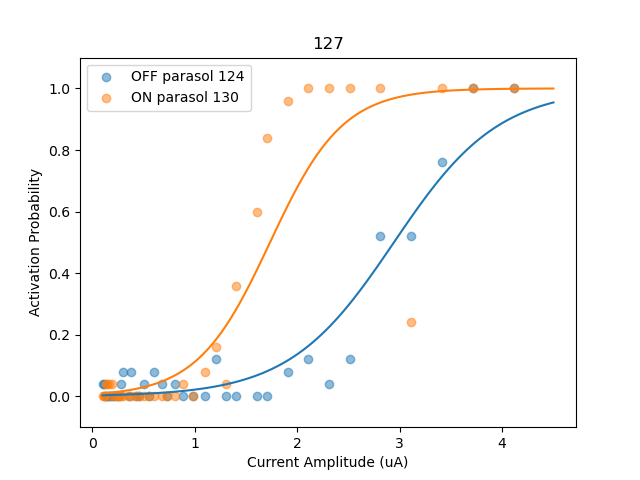

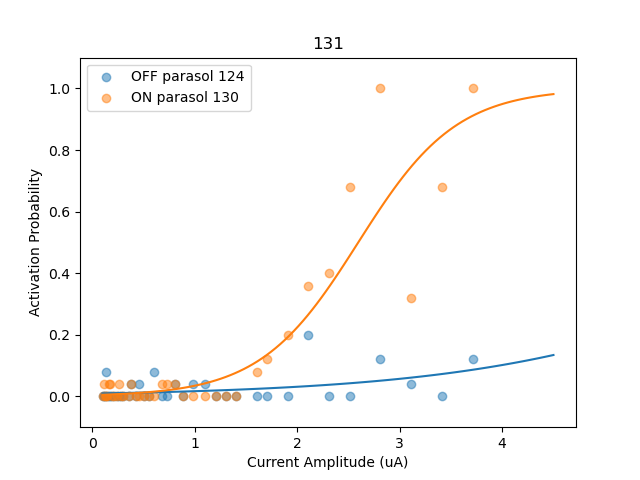

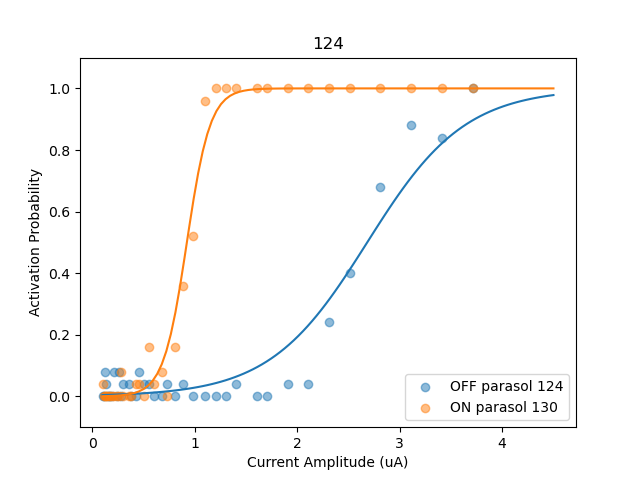

0.044420693343888304

1948
0.0017669048660573505
left
923
0.0021407653336582566
left
658
0.003933233318257345
left
435
0.0013746384049301286
left
341
0.002570875337940537
left
224
0.010972621967969776
left
117
0.04751453789577331
left
64
0.017473775323428975
left
43
0.015474641538219536
left
24
0.014111400445848354
right
19
0.017819308725808503
right
21
0.012243899381004675
right
53
0.04355465818525539
left
27
0.032987912341044257
right
26
0.026185417454437143
right
107
0.008699797348657001
left
61
0.038352994907553284
left
38
0.012757739260631173
left
16
0.022698396715437386
right
22
0.011411790542018463
right
23
0.06978374649691133
right
46
0.03843947233974476
left
17
0.021858551800988835
right
29
0.02624367089723567
right
117
0.02876007728946295
left
61
0.005083239427941533
left
22
0.04635093293528536
right
39
0.01315438717577333
left
18
0.007488349407018702
right
21
0.01304895529575345
right
56
0.011264588665647168
left
22
0.014860533256309316
right
34
0.06222993069019722
left
17
0

/tmp/ipykernel_55384/2804144847.py:52: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


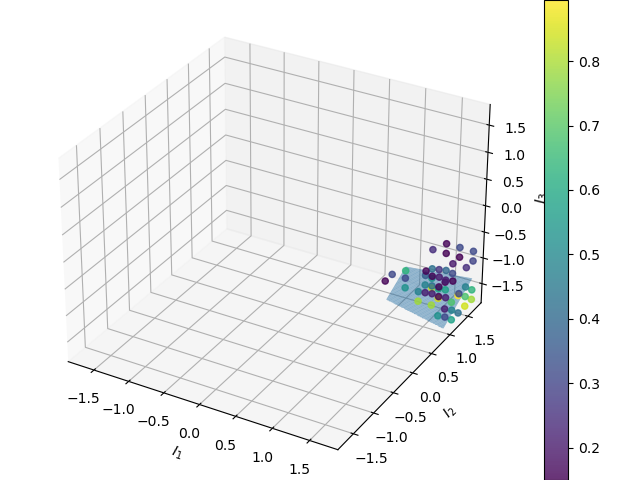

[-5.35352044 -1.18011498  0.20585596 -3.73323626]


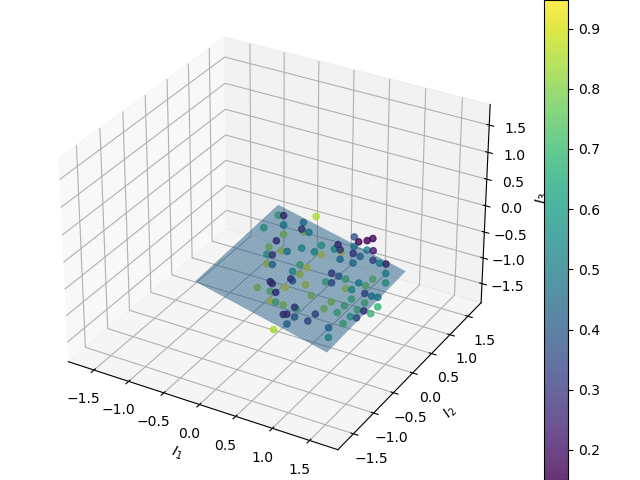

[nan]
[nan]
[nan]
[nan]
[-7.54542683  1.40445505  0.98186939  4.8283946 ]


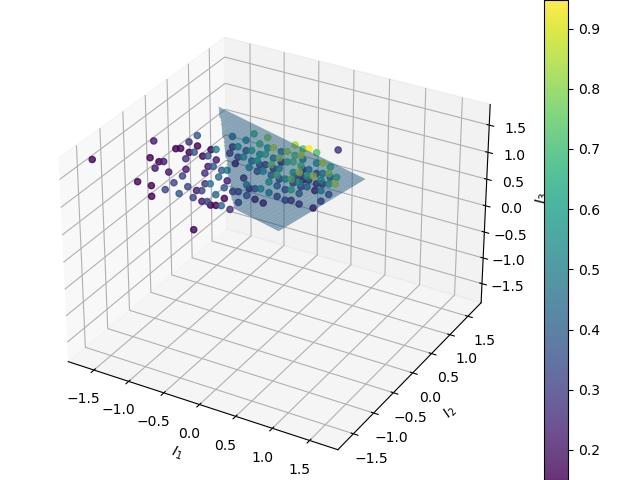

[nan]
[nan]
[nan]
[-7.44316729  1.42487079  1.01458874  4.79077179]


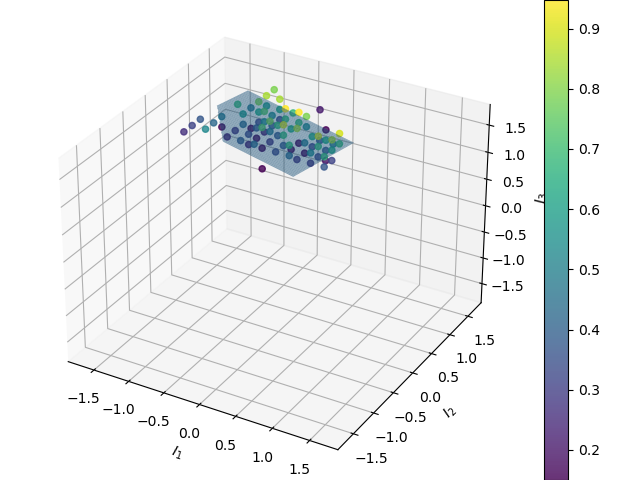

[-7.68425482  2.13456778  1.12936451  5.26202029]


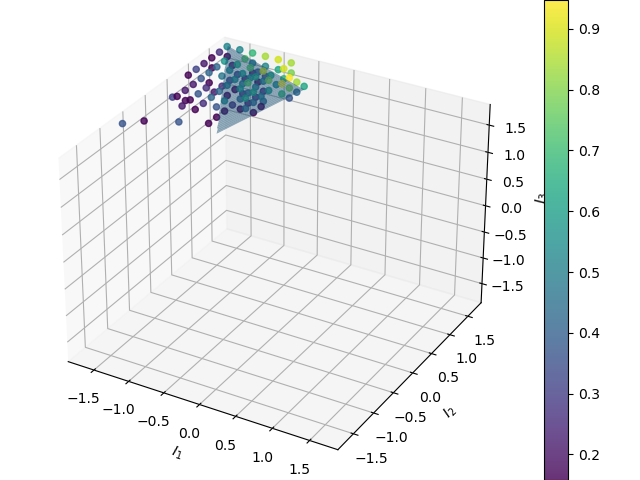

[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]

1415
0.0012209197040367048
left
891
0.019427621597346012
left
516
0.008355211873092738
left
151
0.08687198996525314
left
78
0.08297700046530154
left
37
0.06790483605604047
left
18
0.17130533904282952
right
19
0.04491978101127003
right
41
0.11016653301556478
right
73
0.09360770868394985
left
47
0.09107825793588231
left
29
0.09586239043966294
right
18
0.059287456832867624
right
26
0.05975008462677667
right
365
0.0055353459055740295
left
209
6.913721703716291e-05
left
86
0.03989278891939374
left
43
0.05950887065561905
left
12
0.07464897777309831
right
31
0.06768593555894042
left
11
0.20174826092738418
right
20
0.034986019475809704
right
43
0.04672098596038721
left
28
0.03677738374965178
right
15
0.03520633652507987
right
123
0.0070394342015599465
left
74
0.09674173182505652
left
47
0.04588388890228445
left
17
0.0436092840307154
right
30
0.0

/tmp/ipykernel_55384/2804144847.py:52: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


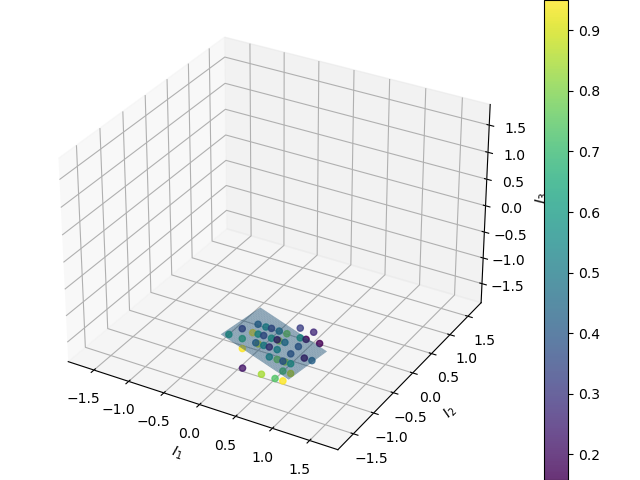

[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[-8.13482239 -3.54399225 -1.83050001 -5.53244268]


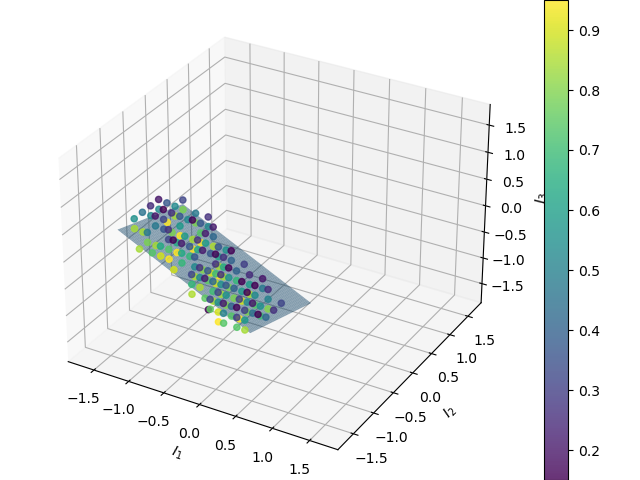

[-6.29387048 -0.816455    0.54629738 -4.12604393]


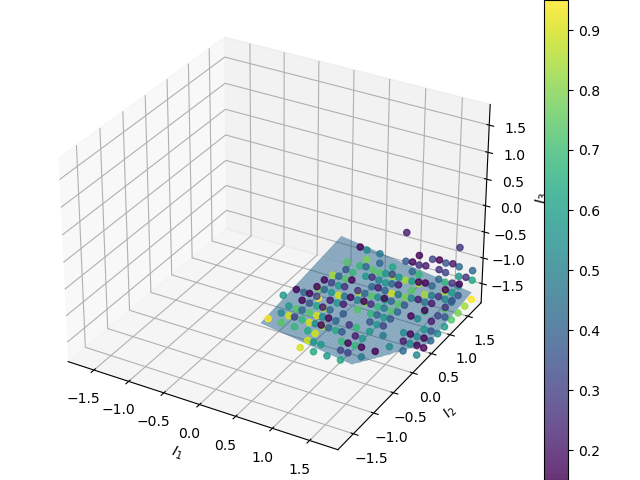

[-7.60330939 -2.24908762 -0.04644821 -5.36898068]


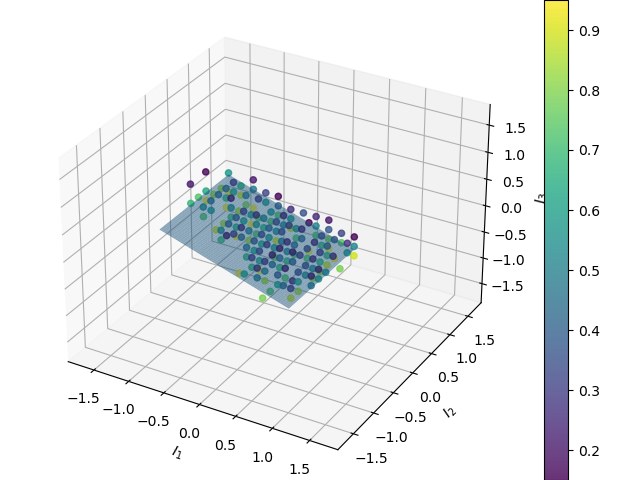

[-5.25739498  0.90544726  0.73377581  3.41021817]


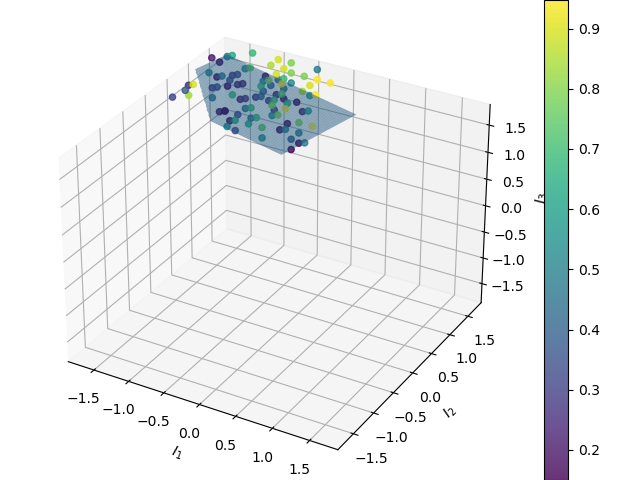

[nan]
[-5.7081138   1.43548167  0.98419224  3.73824964]


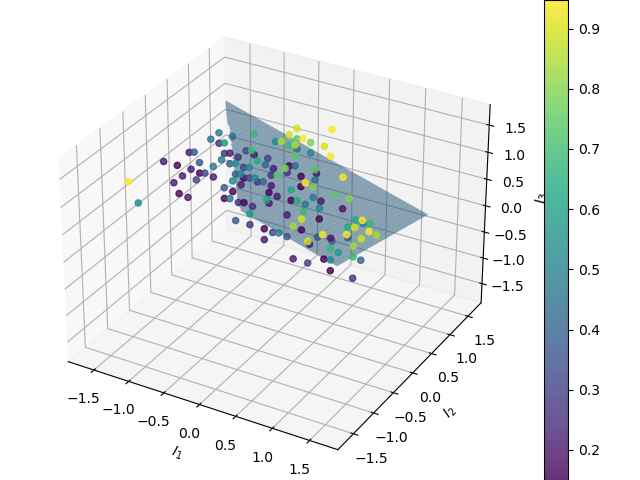

[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
0
Optimal value 1.2641430473554478
optimal p_t 0.5610329132964877
optimal p_n 0.3251070297170732
optimal T_t -0.2453551358554243
optimal T_n -0.7303996654348871
[ 1.78125     1.78125    -1.46500842]
1
Optimal value 1.8579685135327073
optimal p_t 0.49138117141147286
optimal p_n 0.4514200956768327
optimal T_t 0.034478729591487144
optimal T_n -0.19493456504624387
[ 0.16663245  0.43585077 -1.45342119]
2
Optimal value 1.919228319693965
optimal p_t 0.5334881882574055
optimal p_n 0.5109480570335059
optimal T_t -0.13415359051145742
optimal T_n 0.043799228727148885
[ 0.58952212 -1.78124986  1.78124998]
3
Optimal value 1.9289021412021186
optimal p_t 0.53074908904012
optimal p_n 0.5109480803247021
optimal T_t -0.12315176744340214
optimal T_n 0.043799321936621505
[ 0.58952202 -1.7812496   1.78124997]
4
Optimal value 1.2961810607444408
optimal p_t 0.6500399360020322
optimal p_n 0.43111160936469906
optimal T_t -0.619

/tmp/ipykernel_55384/2332213779.py:44: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


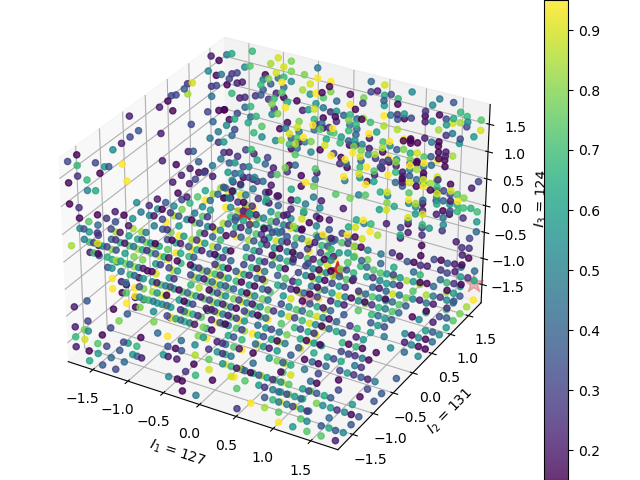

/tmp/ipykernel_55384/2332213779.py:64: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


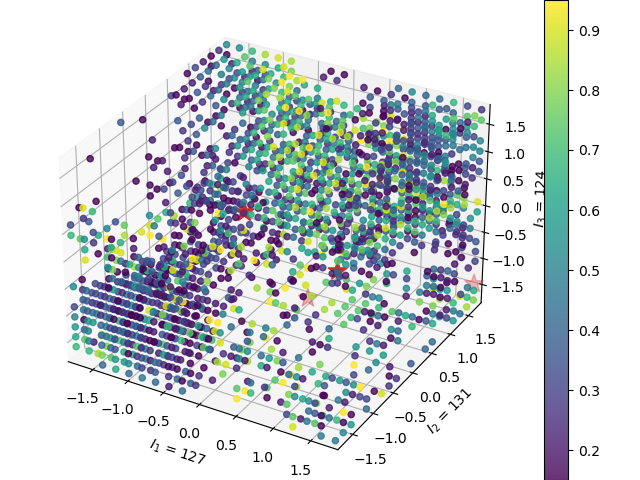

In [17]:
Imax = 1.78125
for m in range(len(all_targets)):
    m = 0
    print(m)
    targets = all_targets[m]
    nontargets = all_nontargets[m]

    classification = classifySelectivity(targets, nontargets)
    print(targets, nontargets, classification)
    
    best_1elec = get1elecSelectivity(dataset, electrical_path, gsort_path_1elec, estim_1elec, 
                                     wnoise, p, targets, nontargets, spont_limit=0.25, noise_limit=0.15, show_plots=True)
    
    print(best_1elec)
    
    t_weights, t_amps, t_probs = fitMultielecSurface(electrical_path, gsort_path, dataset, estim, wnoise, p,
                                                     targets, downsample=False, downsample_trials=10, 
                                                     downsample_factor=2, load_from_mat=True, R2_thr=0.1, 
                                                     min_points_per_cluster=30, show_plots=True, verbose=True)
    nt_weights, nt_amps, nt_probs = fitMultielecSurface(electrical_path, gsort_path, dataset, estim, wnoise, p,
                                                        nontargets, downsample=False, downsample_trials=10, 
                                                        downsample_factor=2, load_from_mat=True, R2_thr=0.1, 
                                                        min_points_per_cluster=30, show_plots=True, verbose=True)
    
    target_combos_flat = cartesian_product_pp(t_weights)
    target_combos = np.reshape(target_combos_flat, (len(target_combos_flat), len(targets), 
                                                int(target_combos_flat.shape[-1] / len(targets))))
    
    nt_weights = np.vstack((nt_weights))

    selec_vals, x_vals = computeSelecVec(target_combos, nt_weights, I_max=Imax, verbose=True)
    print(selec_vals, x_vals)
    selec_vec = x_vals[np.argsort(selec_vals)[-1]]
    print(selec_vec)
    best_multielec = np.amax(selec_vals)
    print(best_multielec)
    
    selec_comparison.append((best_1elec, best_multielec, classification))
    
    multi_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    for i in range(len(nt_amps)):
        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig)
        plt.xlabel(r'$I_1$ = ' + str(multi_elecs[0]))
        plt.ylabel(r'$I_2$ = ' + str(multi_elecs[1]))
        plt.xlim(-Imax, Imax)
        plt.ylim(-Imax, Imax)
        ax.set_zlim(-Imax, Imax)
        ax.set_zlabel(r'$I_3$ = ' + str(multi_elecs[2]))

        scat = ax.scatter(nt_amps[i][:, 0], 
                    nt_amps[i][:, 1],
                    nt_amps[i][:, 2], marker='o', s=20, c=nt_probs[i], alpha=0.8)

        ax.scatter(x_vals[:, 0], x_vals[:, 1], x_vals[:, 2], c='tab:red', marker='*', s=200)

        clb = plt.colorbar(scat)
        plt.show()
        
    for i in range(len(t_amps)):
        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig)
        plt.xlabel(r'$I_1$ = ' + str(multi_elecs[0]))
        plt.ylabel(r'$I_2$ = ' + str(multi_elecs[1]))
        plt.xlim(-Imax, Imax)
        plt.ylim(-Imax, Imax)
        ax.set_zlim(-Imax, Imax)
        ax.set_zlabel(r'$I_3$ = ' + str(multi_elecs[2]))

        scat = ax.scatter(t_amps[i][:, 0], 
                    t_amps[i][:, 1],
                    t_amps[i][:, 2], marker='o', s=20, c=t_probs[i], alpha=0.8)

        ax.scatter(x_vals[:, 0], x_vals[:, 1], x_vals[:, 2], c='tab:red', marker='*', s=200)

        clb = plt.colorbar(scat)
        plt.show()

    break

In [18]:
selec_vals

array([0.37863717, 0.26956184, 0.26090344, 0.25956386, 0.36980017])

In [19]:
selec_comparison

[(0.044420693343888304, 0.3786371692811503, 'ON/OFF')]

In [ ]:
plt.figure()
for i in range(len(selec_comparison)):
    if selec_comparison[i][2] == 'ON/OFF':
        color = 'tab:blue'
    if selec_comparison[i][2] == 'ON/ON':
        color = 'tab:red'
    if selec_comparison[i][2] == 'OFF/OFF':
        color = 'tab:orange'
    if selec_comparison[i][2] == 'mixed':
        color = 'tab:purple'
    plt.scatter(np.array(selec_comparison)[i, 0].astype(float), 
                np.array(selec_comparison)[i, 1].astype(float), alpha=0.5, c=color)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle='--', c='k')
plt.xlabel('Single-electrode selectivity')
plt.ylabel('Triplet selectivity')
leg = plt.legend(['OFF/OFF'])#, 'ON/ON', 'OFF/OFF', 'mixed'])
leg.legendHandles[0].set_color('tab:orange')
# leg.legendHandles[1].set_color('tab:red')
# leg.legendHandles[2].set_color('tab:orange')
# leg.legendHandles[3].set_color('tab:purple')